<a href="https://colab.research.google.com/github/qwasd34/DEV_DATA/blob/main/%5B%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%A7%88%EC%9D%B4%EB%8B%9D%5D_%E1%84%83%E1%85%B5%E1%86%B8%E1%84%85%E1%85%A5%E1%84%82%E1%85%B5%E1%86%BC_%E1%84%86%E1%85%A9%E1%84%83%E1%85%A6%E1%86%AF%E1%84%8B%E1%85%B3%E1%86%AF_%E1%84%92%E1%85%AA%E1%86%AF%E1%84%8B%E1%85%AD%E1%86%BC%E1%84%92%E1%85%A1%E1%86%AB_%E1%84%86%E1%85%AE%E1%86%AB%E1%84%8C%E1%85%A1%E1%86%BC_%E1%84%87%E1%85%AE%E1%86%AB%E1%84%85%E1%85%B2_%E1%84%89%E1%85%B5%E1%86%AF%E1%84%89%E1%85%B3%E1%86%B8_huggingface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hugging Face 사용
- 다양한 연구 결과물들 사용 가능
https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest

- 이모델은 bert 라는 딥러닝 모델개선
- 학습을 따로 진행 x




# 데이터 로드



In [1]:
import pandas as pd

file_path = 'yelp_labelled.txt'
data = pd.read_csv(file_path, names=['text', 'sentiment'], sep='\t')

data.head()

,text,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


- 딥러닝 모델의 전처리는 모델마다 상이함
- HuggingFace 는 특정 모델에 맞는 전처리 코드 제공
- 모델 HF 페이지에 이름 제공하면 전처리 Tokenizer 제공
  - Auto: HF페이지 이름만으로 목표하는것들을 자동으로 가져옴
- Stop words, stemming 사용하지않음 -> (딥러닝쪽에서는 많이 사용 x)


**Token 의 index**
- Token과 Embedding vector 사이를 이어주는 mapping value

장점
- 메모리적 이득
  - token 은 글의 형태이므로 메모리 많이 차지함
  - 특정 token 이 몇번째 index token 인지만 약속해두면 단순 정수인 index 값만 넘겨주면 메모리 절약이 좋음

- Embedding Vector 를 모델에 귀속시켜 관리용이성 높음
  - 딥러닝 모델은 word2Vec 이나 GloVe 와 같이 독립적인 Embedding 을 사용하지않음
  - 모델의 특성에 맞는 Embedding 모델을 각자 설계
  - 모델 구조의 앞단에 Embedding 을 삽입

- index 는 Embedding Vector 가 쌓여있는 순서를 의미!

# 전처리 (Tokenize + alpha)

- Stop word 제거 & Stemming 과정은 사용하지 않음

In [4]:
from transformers import AutoTokenizer

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [5]:
text = data['text'][0]
print(text)

Wow... Loved this place.


In [11]:
tokenized = tokenizer(text, return_tensors='pt') # 출력결과를 pt 자료형 ! Pytorch
print(tokenized)

{'input_ids': tensor([[    0, 23692,   734,   226, 12677,    42,   317,     4,     2]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [12]:
# 실제 Token의 값을 글자의 형태로 확인하려면
# convert_ids_to_tokens 함수를 활용
tokenizer.convert_ids_to_tokens(tokenized['input_ids'].tolist()[0])
# 이 모델의 Token은 단어의 시작을 나타내는 글자에도 추가 처리를 진행!

['<s>', 'Wow', '...', 'ĠL', 'oved', 'Ġthis', 'Ġplace', '.', '</s>']

# 모델 호출

In [14]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
print(model)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [16]:
# [참고] index를 바탕으로 embedding 값을 알아보기
# 모델의 구조를 바탕으로 embedding 부분만 추론 진행

emb = model.roberta.embeddings(**{'input_ids':tokenized['input_ids']})
print('Embedding 값 : ')
print(emb)

# 9개의 Token이 입력되었고,
# 각 Token은 768짜리 vector로 변환
print('Embedding 출력의 크기 : ', emb.shape)

Embedding 값 : 
tensor([[[ 0.0633, -0.0212,  0.0193,  ..., -0.0826, -0.0200, -0.0056],
         [ 0.0161,  0.4771,  0.3319,  ...,  0.2406,  0.1631, -0.0477],
         [ 0.3196, -0.0508, -0.1949,  ..., -0.3173, -0.2470,  0.1839],
         ...,
         [ 0.4359, -0.1863, -0.2228,  ...,  0.2046,  0.0033, -0.1896],
         [ 0.3981, -0.1241, -0.2193,  ..., -0.7940, -0.0644,  0.0779],
         [ 0.1316, -0.0281, -0.0168,  ...,  0.1175,  0.0908, -0.0614]]],
       grad_fn=<NativeLayerNormBackward0>)
Embedding 출력의 크기 :  torch.Size([1, 9, 768])


# 모델 사용

In [17]:
# 모델을 사용한다면 Token 값으로 나온
# input_ids를 key_value 형태로 넣어주면 됨
# https://huggingface.co/docs/transformers/main/en/model_doc/roberta#transformers.RobertaForSequenceClassification.forward.input_ids

output = model(input_ids = tokenized['input_ids'])

# 혹은 사용 예제에서 처럼
# Unpacking 사용도 가능
# https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest#full-classification-example

output = model(**tokenized)

# 출력 확인 및 해석

In [18]:
# 모델의 출력 결과
# 학습 과정에서도 쓰이는 다양한 결과가 존재
print(output)

SequenceClassifierOutput(loss=None, logits=tensor([[-1.7095, -1.1774,  3.0097]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)


In [19]:
# 타겟하는 정보인 점수 값을 가져옴  logits=tensor([[-1.7095, -1.1774,  3.0097]]
scores = output[0][0].detach().numpy()
print(scores)

[-1.709534  -1.1773801  3.0097373]


In [20]:
# 점수를 확률의 형태로 변환
# 과정에성 softmax 함수를 사용하고
# 외부 패키지의 함수를 활용

from scipy.special import softmax

scores = softmax(scores)
print(scores)

[0.00871163 0.01483237 0.97645605]


In [22]:
# 모델 학습 정보를 확인하기 위한 config 값 로딩
 #negative": 0,
  #  "neutral": 1,
  #  "positive": 2


from transformers import AutoConfig
config = AutoConfig.from_pretrained(MODEL)

config

RobertaConfig {
  "_name_or_path": "cardiffnlp/twitter-roberta-base-sentiment-latest",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.42.4",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

In [23]:
# 최종적으로 확률이 제일 큰 값의 인덱스를 바탕으로 감정을 판단
import numpy as np

max_prob_index = np.argmax(scores)
results = config.id2label[max_prob_index]
results

'positive'

In [28]:
# 최종 함수로 표현
def sentiment_analysis(sentence, tokenizer, model, config):
    tokenized = tokenizer(sentence, return_tensors='pt')
    output = model(input_ids = tokenized['input_ids'])

    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    max_prob_index = np.argmax(scores)
    results = config.id2label[max_prob_index]
    return results, max_prob_index

In [29]:
sent = data['text'][2]
res, idx = sentiment_analysis(sent, tokenizer, model, config)
print(sent)
print('-> ', idx, res)

Not tasty and the texture was just nasty.
->  0 negative


# 평가 데이터 생성 - 전에 머신러닝 모델과 비교

In [30]:
from sklearn.model_selection import train_test_split

X = np.stack(data['text'].values)
y = np.stack(data['sentiment'].values)

# 훈련 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# 머신러닝 에서는 0과1밖에 안나옴. 지금은 0, 1,2  강제로 1을 -1로 바꿔서 머신러닝결과랑 맞춰줌
def convertResults(index):
    if index == 0 : return index
    elif index == 1 : return -1
    elif index == 2 : return 1

In [32]:
# 평가 데이터에 대해 전체 추론 진행
predictions = []

for test in X_test :
    res, idx = sentiment_analysis(test, tokenizer, model, config)
    idx = convertResults(idx)
    predictions.append(idx)

predictions = np.array(predictions)

In [33]:
predictions

array([-1,  1,  1,  1,  1,  1,  0,  1,  0,  1,  0,  0,  0,  0, -1,  1,  1,
        0,  0, -1,  1,  1,  0,  1,  0,  0,  1,  0,  0,  0,  1,  1,  0,  1,
        0,  1,  1, -1,  1,  0,  0,  1,  1,  0,  1,  1,  0, -1, -1,  0,  0,
        0, -1,  1,  1,  1, -1,  1,  0,  0, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  0,  1,  1,  1,  0,  1,  0,  1,  0,  0,  0,  0,  1,  1,  1,  1,
        0,  0,  1,  1,  1,  1,  1,  0,  0,  1,  1,  1,  1,  1,  0,  1,  0,
        0,  1,  1,  0,  0, -1,  0,  0,  1, -1,  0,  0,  0,  1,  1,  0,  0,
        1, -1,  1,  0,  1,  1,  1,  1,  1,  1,  0,  0,  0,  1,  0,  1,  1,
        0,  1,  1,  0,  0,  1,  1,  0,  0,  0,  0,  0,  1,  0, -1,  1,  0,
        1, -1, -1,  1,  0,  0,  0,  1,  1,  0,  0,  1, -1,  0,  1,  1,  1,
        1,  1,  0,  0,  1,  0,  1,  0,  0,  0,  1,  0,  1,  0,  0,  1,  1,
        0,  0,  1,  0,  0,  1,  1, -1,  1,  1, -1,  0,  1])

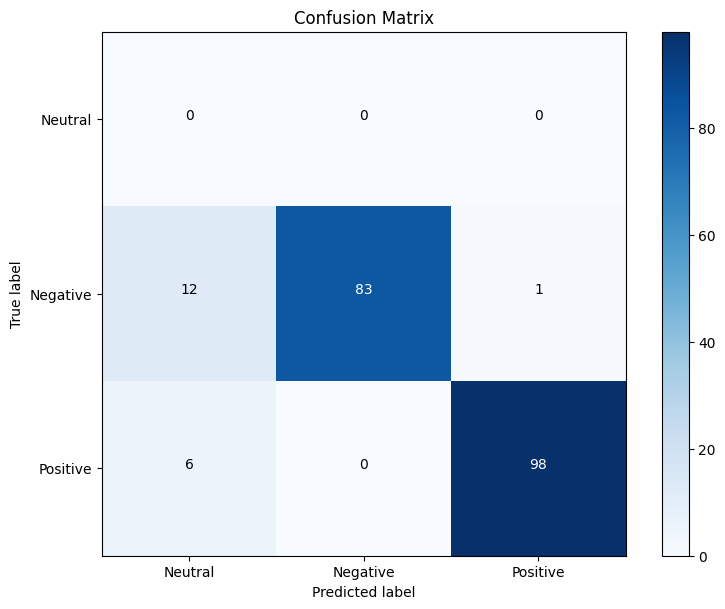

In [34]:
# 분류 문제이므로 분류 과정에서 많이 사용하는 평가 척도 사용

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions)

import matplotlib.pyplot as plt
# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(3)
plt.xticks(tick_marks, ['Neutral', 'Negative', 'Positive'])
plt.yticks(tick_marks, ['Neutral', 'Negative', 'Positive'])

# 각 칸에 실제 값 표시
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Precision, Recall, F1-Score 계산
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='micro') # 모든 클래스의 결과를 합산하여 계산
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')

# 결과 출력
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy: 0.91
Precision: 0.91
Recall: 0.91
F1-Score: 0.91


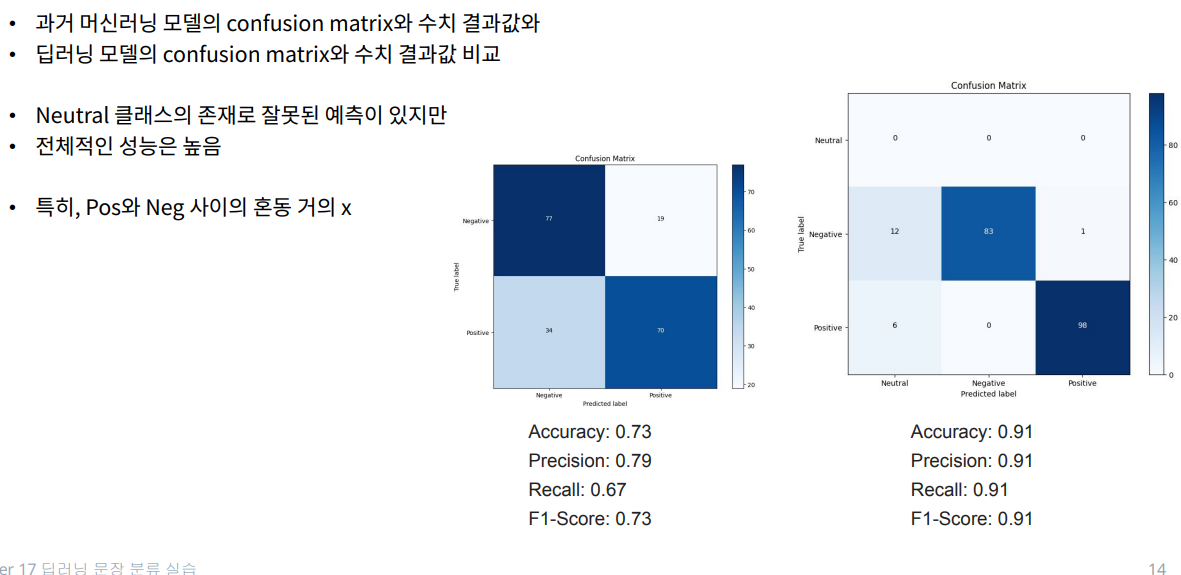

# 가상 데이터를 활용한 문장 분석 결과 확인

In [37]:
# 음식점에 대한 만족도 관련 텍스트를 임의로 생성

examples = [
    "This restaurant had the best service I've ever experienced.", # 긍정적
    "Extremely disappointed with the late delivery.", # 부정적
    "The ambiance was enchanting and very relaxing.", # 긍정적
    "Unfortunately, the food was bad and uninspired.", # 부정적
    "Amazing cocktails and a vibrant atmosphere!", # 긍정적
    "Waited an hour for our table, even with a reservation.", # 부정적
    "The pasta dish was a delightful surprise with its rich flavors.", # 긍정적
    "Too noisy to enjoy our meal, and the tables were too close together.", # 부정적
    "Exceptional customer service and a very friendly staff.", # 긍정적
    "The dessert was undercooked and not what we expected.", # 부정적
]

In [38]:
# 가상 데이터를 활용한 예측 진행

for idx, exp in enumerate(examples) :
    res, index = sentiment_analysis(exp, tokenizer, model, config)
    origin_sent = '긍정적' if idx % 2 == 0 else '부정적'
    if index == 0 : pred_sent = '부정적'
    elif index == 1 : pred_sent = '중립'
    else : pred_sent = '긍정적'

    print(f"문장: {exp} \n원래 감정 : {origin_sent} / 예측 : {pred_sent}", end='\n\n')

문장: This restaurant had the best service I've ever experienced. 
원래 감정 : 긍정적 / 예측 : 긍정적

문장: Extremely disappointed with the late delivery. 
원래 감정 : 부정적 / 예측 : 부정적

문장: The ambiance was enchanting and very relaxing. 
원래 감정 : 긍정적 / 예측 : 긍정적

문장: Unfortunately, the food was bad and uninspired. 
원래 감정 : 부정적 / 예측 : 부정적

문장: Amazing cocktails and a vibrant atmosphere! 
원래 감정 : 긍정적 / 예측 : 긍정적

문장: Waited an hour for our table, even with a reservation. 
원래 감정 : 부정적 / 예측 : 부정적

문장: The pasta dish was a delightful surprise with its rich flavors. 
원래 감정 : 긍정적 / 예측 : 긍정적

문장: Too noisy to enjoy our meal, and the tables were too close together. 
원래 감정 : 부정적 / 예측 : 부정적

문장: Exceptional customer service and a very friendly staff. 
원래 감정 : 긍정적 / 예측 : 긍정적

문장: The dessert was undercooked and not what we expected. 
원래 감정 : 부정적 / 예측 : 부정적

